<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_08_auto_ml_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Tuning

In [1]:
COLAB = False

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2_v3'

In [2]:
# !pip install -U imblearn
# !pip install -U xgboost
# !pip install -U featuretools

In [3]:
if COLAB:
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects

In [4]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .
  !cp dl-projects/plot* .

In [5]:
%load_ext autoreload
# %reload_ext autoreload
%autoreload 2

%matplotlib inline

In [6]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math 
import matplotlib
import sys
import gc

from scipy import stats
from collections import Counter
from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

import featuretools as ft
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, precision_recall_curve, make_scorer, recall_score, roc_curve, mean_squared_error, accuracy_score, average_precision_score, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV, StratifiedShuffleSplit, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import (RandomUnderSampler, 
                                     ClusterCentroids,
                                     TomekLinks,
                                     NeighbourhoodCleaningRule,
                                     AllKNN,
                                     NearMiss,
                                     OneSidedSelection)
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.metrics import classification_report_imbalanced 
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN
import pylab as pl
import xgboost as xgb
from collections import Counter
from dateutil.relativedelta import relativedelta


# from skopt import BayesSearchCV
# from skopt.space import Real, Categorical, Integer
# from scikitplot.plotters import plot_precision_recall_curve

from utils import feature_selection, plot_feature_importances
from preprocess import *
from plot import plot_correlation_matrix, plot_labeled_scatter

from IPython.display import display

np.set_printoptions(threshold=sys.maxsize)

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [7]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [8]:
if COLAB:
  from google.colab import drive
  drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')

In [9]:
if COLAB:
  DATASET_PATH = GDRIVE_DATASET_FOLDER
  ORIGIN_DATASET_PATH = Path('dl-projects/datasets')
else:
  DATASET_PATH = Path("../datasets")
  ORIGIN_DATASET_PATH = Path('datasets')

DATASET = DATASET_PATH/f"{FEATURE_DATASET_PREFIX}.ft"
ORIGIN_DATASET = ORIGIN_DATASET_PATH/DATASET_NAME

if COLAB:
  !ls -l gdrive/"My Drive"/datasets/ --block-size=M
  !ls -l dl-projects/datasets --block-size=M

In [10]:
# Read the data
data = pd.read_feather(DATASET)
origin_data = format_tabular(ORIGIN_DATASET)

## Exploratory Data Analysis

### View data

In [11]:
# Feature matrix
feature_matrix = data.drop(columns=['NumberId', 'month', 'year'])

In [12]:
# Sort data
feature_matrix.sort_values(by=['time', 'MAX(Results.LuckyNo)'], inplace=True)
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 959893 entries, 7020 to 956511
Columns: 214 entries, time to LAST(Results.PrizeType)_Prize
dtypes: datetime64[ns](1), float64(155), int64(56), uint8(2)
memory usage: 1.5 GB


In [13]:
print('Distribution')
print(feature_matrix['Label'].value_counts())
print()
print('Positive: ' + str(feature_matrix['Label'].value_counts()[0]) + ' which is ', round(feature_matrix['Label'].value_counts()[0]/len(feature_matrix) * 100,2), '% of the dataset')
print('Negative: ' + str(feature_matrix['Label'].value_counts()[1]) + ' which is ', round(feature_matrix['Label'].value_counts()[1]/len(feature_matrix) * 100,2), '% of the dataset')

Distribution
0    927839
1     32054
Name: Label, dtype: int64

Positive: 927839 which is  96.66 % of the dataset
Negative: 32054 which is  3.34 % of the dataset


In [14]:
feature_matrix.isna().sum().sort_values(ascending=False)

SKEW(Results.TIME_SINCE_PREVIOUS(DrawDate))               7636
CUM_MEAN(TREND(Results.LuckyNo, DrawDate))                7636
TREND(Results.TIME_SINCE_PREVIOUS(DrawDate), DrawDate)    7636
TREND(Results.CUM_MEAN(TotalStrike), DrawDate)            7636
TREND(Results.CUM_SUM(LuckyNo), DrawDate)                 7636
                                                          ... 
CUM_SUM(MIN(Results.DrawNo))                                 0
NUM_UNIQUE(Results.DAY(DrawDate))                            0
NUM_UNIQUE(Results.MONTH(DrawDate))                          0
SUM(Results.PERCENTILE(LuckyNo))                             0
time                                                         0
Length: 214, dtype: int64

### Feature Selection

In [15]:
# Fill all NaN with 0
feature_matrix = feature_matrix.fillna(0)

In [16]:
feature_matrix.shape

(959893, 214)

In [17]:
feature_matrix_selection = feature_selection(feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label']))
# feature_matrix_selection = feature_matrix.drop(columns = ['time', 'TotalStrike', 'Label'])

Original shape:  (959893, 211)
0 missing columns with threshold: 90.
41 zero variance columns.
109 collinear columns removed with threshold: 0.95.
Total columns removed:  150
Shape after feature selection: (959893, 61).


In [18]:
feature_matrix_selection.shape, feature_matrix_selection.columns

((959893, 61),
 Index(['STD(Results.DrawNo)', 'MAX(Results.DrawNo)', 'MAX(Results.LuckyNo)',
        'MIN(Results.DrawNo)', 'MEAN(Results.DrawNo)', 'SKEW(Results.DrawNo)',
        'AVG_TIME_BETWEEN(Results.DrawDate)', 'COUNT(Results)',
        'SUM(Results.DrawNo)', 'SUM(Results.LuckyNo)',
        'TREND(Results.DrawNo, DrawDate)', 'MONTH(first_Results_time)',
        'DAY(first_Results_time)', 'TIME_SINCE(first_Results_time)',
        'TIME_SINCE_PREVIOUS(first_Results_time)',
        'STD(Results.PERCENTILE(DrawNo))',
        'STD(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'STD(Results.CUM_SUM(DrawNo))', 'STD(Results.CUM_MEAN(LuckyNo))',
        'MAX(Results.PERCENTILE(DrawNo))',
        'MAX(Results.PERCENTILE(TotalStrike))',
        'MAX(Results.CUM_MEAN(LuckyNo))',
        'MIN(Results.TIME_SINCE_PREVIOUS(DrawDate))',
        'MIN(Results.CUM_MEAN(LuckyNo))', 'MODE(Results.MONTH(DrawDate))',
        'MODE(Results.DAY(DrawDate))', 'MEAN(Results.TIME_SINCE(DrawDate))',
       

In [19]:
feature_matrix_selection['time'] = feature_matrix['time']
feature_matrix_selection['TotalStrike'] = feature_matrix['TotalStrike']
feature_matrix_selection['Label'] = feature_matrix['Label']

### Feature Correlation

In [20]:
# Check with feature selection
corrs = feature_matrix_selection.corr().sort_values('Label')

In [21]:
corrs['Label'].tail(60)

STD(Results.CUM_SUM(DrawNo))                             -0.002778
MAX(Results.LuckyNo)                                     -0.002680
SUM(Results.LuckyNo)                                     -0.002426
MAX(Results.DrawNo)                                      -0.002377
MIN(Results.CUM_MEAN(LuckyNo))                           -0.002333
CUM_MEAN(AVG_TIME_BETWEEN(Results.DrawDate))             -0.002238
MEAN(Results.TIME_SINCE(DrawDate))                       -0.002056
STD(Results.PERCENTILE(DrawNo))                          -0.001937
PERCENTILE(STD(Results.LuckyNo))                         -0.001931
PERCENTILE(STD(Results.DrawNo))                          -0.001814
CUM_SUM(SKEW(Results.DrawNo))                            -0.001741
SUM(Results.TIME_SINCE(DrawDate))                        -0.001492
MEAN(Results.CUM_MEAN(LuckyNo))                          -0.001477
AVG_TIME_BETWEEN(Results.DrawDate)                       -0.001429
PERCENTILE(SKEW(Results.DrawNo))                         -0.00

## Modeling

In [22]:
def recall_optim(y_true, y_pred):
    """Make a scoring function that improves specificity while identifying all strikes
    """
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Recall will be worth a greater value than specificity
    rec = recall_score(y_true, y_pred) * 0.8 
    spe = conf_matrix[0,0]/conf_matrix[0,:].sum() * 0.2 
    
    # Imperfect recalls will lose a penalty
    # This means the best results will have perfect recalls and compete for specificity
    if rec < 0.8:
        rec -= 0.2
    return rec + spe 


# Make a scoring callable from recall_score
recall = make_scorer(recall_score)

# Create a scoring callable based on the scoring function
optimize = make_scorer(recall_optim)

# DataFrame to store classifier performance
performance = pd.DataFrame(columns=['Train_Recall','Test_Recall','Test_Specificity', 'Optimize'])


def score_optimization(dt, feature_matrix, clf, params, X_train, y_train, X_test, y_test, skip_grid_search_cv=False, optimized_scorer=False):
    """Find the optimized classifier.
    """
    if not skip_grid_search_cv:
      print("\nFinding the optimized classifier...")

      # Load GridSearchCV
      # search = GridSearchCV(
      search = RandomizedSearchCV(
            estimator=clf,
            #param_grid=params,
            param_distributions=params,
            n_jobs=4,
            scoring=optimize  # Use custom scorer
      )

      # Train search object
      search.fit(X_train, y_train)

      # Heading
      print('\n','-'*40,'\n',clf.__class__.__name__,'\n','-'*40)

      # Extract best estimator
      best = search.best_estimator_
      print('Best parameters: \n\n',search.best_params_,'\n')
    
    else:
      print("\nUse the passed in classifier...\n")
      best = clf

    # Cross-validate on the train data
    print("TRAIN GROUP")
    #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=42)
    cv = 3
    if not optimized_scorer:
      print('\nUse default scorer')
      train_cv = cross_val_score(
                                n_jobs=4,
                                X=X_train, 
                                y=y_train, 
                                estimator=best, 
                                scoring=recall,
                                cv=cv)
    else:
      print('\nUse optimized scorer')
      train_cv = cross_val_score(
                                n_jobs=4,
                                X=X_train, 
                                y=y_train, 
                                estimator=best, 
                                #scoring=optimize,
                                scoring='roc_auc',
                                cv=cv)

    print("\nCross-validation recall scores:",train_cv)
    print("Mean recall score:",train_cv.mean())

    # Now predict on the test group
    print("\nTEST GROUP")
    y_pred = best.fit(X_train, y_train).predict(X_test)
    probas = best.predict_proba(X_test)[:, 1]
    print("\nRecall:",recall_score(y_test,y_pred))

    # Get imbalanced classification report
    print(classification_report_imbalanced(y_test, y_pred))

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test,y_pred)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=plt.cm.copper)
    plt.show()

    # Store results
    performance.loc[clf.__class__.__name__+'_optimize',:] = [
        train_cv.mean(),
        recall_score(y_test,y_pred),
        conf_matrix[0,0]/conf_matrix[0,:].sum(),
        recall_optim(y_test,y_pred)
    ]
    # Look at the parameters for the top best scores
    if not skip_grid_search_cv:
      display(pd.DataFrame(search.cv_results_).iloc[:,4:].sort_values(by='rank_test_score').head())
    display(performance)

    # Additionl info
    print('\n\nAdditional Info')
    print('='*40)
    positive = np.where((y_pred==1))
    print(f'Total predicted to be positive: {len(positive[0])} \n')

    # Total predicted matches
    print('Predicted matches')
    pred = np.where((y_pred==1))
    print(len(pred[0]), pred[0][0:23])
    topN = np.argpartition(probas, -23)[-23:]
    print(f'\n{topN}\n')  # Top N most high probability numbers
  
    if len(positive[0]) > 0:
    
      # Matching draws
      print('Matched draws')
      md = np.where((y_pred==1) & (y_test==1))
      print(f"Count: {len(md[0])}, Index: {md}")
      month_data = feature_matrix.loc[feature_matrix['time'] == dt]
      numbers = month_data.iloc[md[0]][['MAX(Results.LuckyNo)']]

      print('\n\nTop 23 Possibility')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(topN))].head(23))  
      
      print('\n\nFirst 23 Numbers')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(pred[0][0:23]))].head(23))    
             

      print('\n\nAll matched')
      print(origin_data[(origin_data['DrawDate'].dt.year == dt.year) & 
                          (origin_data['DrawDate'].dt.month == dt.month) &  
                          (origin_data['LuckyNo'].isin(numbers['MAX(Results.LuckyNo)']))].head(100))    
                                                  
    else:
      print('No luck this month')  
  

In [23]:
def remove_outliers(balanced, threshold=0.001, remove=True):
    """Removing Outliers from high-correlation features.
    """

    if not remove:
      return balanced

    bal_corr = balanced.corr()
    no_outliers=pd.DataFrame(balanced.copy())

    cols = bal_corr.Label.index[:-1]

    # For each feature correlated with Class...
    for col in cols:
        # If absolute correlation value is more than X percent...
        correlation = bal_corr.loc['Label',col]

        if np.absolute(correlation) > threshold:
          # Separate the classes of the high-correlation column
          nonstrikes = no_outliers.loc[no_outliers.Label==0,col]
          strikes = no_outliers.loc[no_outliers.Label==1,col]

          # Identify the 25th and 75th quartiles
          all_values = no_outliers.loc[:,col]
          q25, q75 = np.percentile(all_values, 25), np.percentile(all_values, 75)
          # Get the inter quartile range
          iqr = q75 - q25
          # Smaller cutoffs will remove more outliers
          cutoff = iqr * 7
          # Set the bounds of the desired portion to keep
          lower, upper = q25 - cutoff, q75 + cutoff
          
          # If positively correlated...
          # Drop nonstrikes above upper bound, and strikes below lower bound
          if correlation > 0: 
              no_outliers.drop(index=nonstrikes[nonstrikes>upper].index,inplace=True)
              no_outliers.drop(index=strikes[strikes<lower].index,inplace=True)
          
          # If negatively correlated...
          # Drop non strikes below lower bound, and strikes above upper bound
          elif correlation < 0: 
              no_outliers.drop(index=nonstrikes[nonstrikes<lower].index,inplace=True)
              no_outliers.drop(index=strikes[strikes>upper].index,inplace=True)
        
    print('\nData shape before removing outliers:', balanced.shape)
    print('\nCounts of strikes VS non-strikes in previous data:')
    print(balanced.Label.value_counts())
    print('-'*40)
    print('-'*40)
    print('\nData shape after removing outliers:', no_outliers.shape)
    print('\nCounts of strikes VS non-strikes in new data:')
    print(no_outliers.Label.value_counts())

    # no_outliers.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
    # plt.title('Distributions with Less Outliers', fontsize=17)
    # plt.show()
    
    no_outliers.reset_index(drop=True, inplace=True)
    return no_outliers


def filter_features(no_outliers, threshold=0.001):
    """Feature selection.
    """
    feat_sel = pd.DataFrame(no_outliers.copy())

    # Make a dataframe with the label-correlations before removing outliers
    # corr_change = pd.DataFrame()
    # corr_change['correlation']= bal_corr.Label
    # corr_change['origin']= 'w/outliers'

    # Make a dataframe with label-correlations after removing outliers 
    # corr_other = pd.DataFrame()
    # corr_other['correlation']= feat_sel.corr().Label
    # corr_other['origin']= 'no_outliers'

    # Join them
    # corr_change = corr_change.append(corr_other)

    # plt.figure(figsize=(14,6))
    # plt.xticks(rotation=90)

    # Plot them
    # sns.set_style('darkgrid')
    # plt.title('Label correlation per feature. With vs without outliers', fontsize=17)
    # sns.barplot(data=corr_change,x=corr_change.index,y='correlation',hue='origin')
    # plt.show()

    # Feature Selection based on correlation with label

    print('\nData shape before feature selection:', feat_sel.shape)
    print('\nCounts of strikes vs non-strikes before feature selection:')
    print(feat_sel.Label.value_counts())
    print('-'*40)

    # Correlation matrix after removing outliers
    new_corr = feat_sel.corr()

    for col in new_corr.Label.index[:-1]:
        # Pick desired cutoff for dropping features. In absolute-value terms.
        if np.absolute(new_corr.loc['Label',col]) < threshold:
            # Drop the feature if correlation is below cutoff
            feat_sel.drop(columns=col,inplace=True)

    print('-'*40)
    print('\nData shape after feature selection:', feat_sel.shape)
    print('\nCounts of strikes vs non-strikes in new data:')
    print(feat_sel.Label.value_counts())

    return feat_sel

    # feat_sel.iloc[:,:-1].boxplot(rot=90,figsize=(16,4))
    # plt.title('Distribution of Features Selected', fontsize=17)
    # plt.show()

def under_sampler(data, sample_size=20000, sampling=False):
    # Undersample model for efficiency and balance classes.

    X_train = data.drop('Label',1)
    y_train = data.Label

    if not sampling:
      return X_train, y_train

    # After feature-selection, X_test needs to include only the same features as X_train
    # cols = X_train.columns
    # X_test = X_test[cols]

    # Undersample and balance classes
    X_train, y_train = RandomUnderSampler(sampling_strategy={1:sample_size,0:sample_size}).fit_resample(X_train,y_train)

    print('\nX_train shape after reduction:', X_train.shape)
    print('\nCounts of strikes VS non-strikes in y_train:')
    print(np.unique(y_train, return_counts=True))

    return X_train, y_train

In [24]:
def gen_train_test_set(dt, feature_matrix, file_prefix='data'): 
    
    # Subset labels
    test_labels = feature_matrix.loc[feature_matrix['time'] == dt, 'Label']
    train_labels = feature_matrix.loc[feature_matrix['time'] < dt, 'Label']

    # Features
    X_train = feature_matrix[feature_matrix['time'] < dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    X_test = feature_matrix[feature_matrix['time'] == dt].drop(columns = ['NumberId', 'time', 'Label', 'TotalStrike', 'month', 'year', 'index'], errors='ignore')
    feature_names = list(X_train.columns)
    
    # Labels
    y_train = np.array(train_labels).reshape((-1, ))
    y_test = np.array(test_labels).reshape((-1, ))
    
    print('Training on {} observations.'.format(len(X_train)))
    print('Testing on {} observations.\n'.format(len(X_test)))

    # Join the train data
    train = X_train.join(train_labels)

    print('Data shape before balancing:', train.shape)
    print('\nCounts of strikes vs non-strikes in previous data:')
    print(train.Label.value_counts())
    print('-'*40)

    # sklearn pipeline
    pipeline = make_pipeline(
        SimpleImputer(strategy = 'constant', fill_value=0),
        StandardScaler())
    
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.transform(X_test)

    # imblearn pipeline
    imb_pipeline = make_pipeline_imb(
          # NearMiss(version=3, n_neighbors_ver3=3, n_jobs=4)
          # SMOTE(sampling_strategy='minority',random_state=42, n_jobs=4)
          ADASYN(sampling_strategy='minority',random_state=42, n_jobs=4)
          # OneSidedSelection(n_neighbors=1, n_seeds_S=200, random_state=42, n_jobs=4)
    )
     
    # Balance the data
    to_balanced = True
    if to_balanced:
      print('\nBalancing data')
      X_bal, y_bal = imb_pipeline.fit_resample(X_train, y_train)
      X_bal = pd.DataFrame(X_bal,columns=feature_names)
      y_bal = pd.DataFrame(y_bal,columns=['Label'])
    else:
      print('\nNO balancing')
      X_bal = pd.DataFrame(X_train,columns=feature_names)
      y_bal = pd.DataFrame(y_train,columns=['Label'])

    balanced = X_bal.join(y_bal)

    # print('-'*40)
    print('Data shape after balancing:',balanced.shape)
    print('\nCounts of strikes VS non-strikes in new data:')
    print(balanced.Label.value_counts())

    # Remove high correlation outliers
    no_outliers = remove_outliers(balanced, remove=False)
   
    # Remove features with low correlation
    remove_features = True
    if remove_features:
      print('\nFiltering features')
      features_selected = filter_features(no_outliers)
    else:
      print('\nNO filtering')
      features_selected = no_outliers 

    columns_selected = features_selected.drop('Label',1).columns

    # Under sampling
    X_train, y_train = under_sampler(features_selected, sampling=False) 
    X_train = pd.DataFrame(X_train,columns=columns_selected)
    y_train = pd.DataFrame(y_train,columns=['Label'])

    # For X_test, now only use the selected features
    X_test = pd.DataFrame(X_test,columns=feature_names)
    X_test = X_test[columns_selected]
    y_test = pd.DataFrame(y_test,columns=['Label'])

    #print(X_train.describe())
    #return

    # Save data
    # print(X_train.head(10))
    # print(y_train.head(10)) 

    # print(X_test.head(10))
    # print(y_test.head(10)) 
    X_train.to_feather(DATASET_PATH/f"{file_prefix}_X_train.ft")
    y_train.to_feather(DATASET_PATH/f"{file_prefix}_y_train.ft")
   
    X_test.to_feather(DATASET_PATH/f"{file_prefix}_X_test.ft")
    y_test.to_feather(DATASET_PATH/f"{file_prefix}_y_test.ft")

    gc.collect()


In [25]:
def model(dt, feature_matrix, file_prefix='data', csv=False):
    """Predict for a particular month.

    - https://www.kaggle.com/miguelniblock/optimizing-imbalanced-classification-100-recall
    - https://www.kaggle.com/saxinou/imbalanced-data-xgboost-tunning
    - https://www.kaggle.com/andreanuzzo/balance-the-imbalanced-rf-and-xgboost-with-smote
    - https://github.com/mengwangk/FraudDetection/blob/master/05_Sampling_techniques_for_extremely_imbalanced_data.ipynb
    - https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets
    - https://github.com/coding-maniacs/over-under-sampling/blob/master/src/main.py
    - https://github.com/scikit-learn-contrib/imbalanced-learn/issues/552#issuecomment-466348310
    - https://stackoverflow.com/questions/52499788/smotetomek-how-to-set-ratio-as-dictionary-for-fixed-balance
    - https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.OneSidedSelection.html#imblearn.under_sampling.OneSidedSelection
    - https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn
    - https://machinelearningmastery.com/undersampling-algorithms-for-imbalanced-classification/
    - https://seaborn.pydata.org/generated/seaborn.heatmap.html
    - https://stats.stackexchange.com/questions/243207/what-is-the-proper-usage-of-scale-pos-weight-in-xgboost-for-imbalanced-datasets
    - https://scikit-learn.org/stable/auto_examples/svm/plot_oneclass.html#sphx-glr-auto-examples-svm-plot-oneclass-py
    - https://machinelearningmastery.com/cost-sensitive-logistic-regression/
    
    - https://datascience.stackexchange.com/questions/28285/what-is-the-best-way-to-deal-with-imbalanced-data-for-xgboost/28292
    - https://machinelearningmastery.com/xgboost-for-imbalanced-classification/
    - https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/
    
    """

    # Read data
    if not csv:
      X_train = pd.read_feather(DATASET_PATH/f"{file_prefix}_X_train.ft")
      y_train = pd.read_feather(DATASET_PATH/f"{file_prefix}_y_train.ft")
    
      X_test = pd.read_feather(DATASET_PATH/f"{file_prefix}_X_test.ft")
      y_test = pd.read_feather(DATASET_PATH/f"{file_prefix}_y_test.ft")
    else:
      X_train = pd.read_csv(DATASET_PATH/f"{file_prefix}_X_train.csv", header=0, sep=',', quotechar='"')
      y_train = pd.read_csv(DATASET_PATH/f"{file_prefix}_y_train.csv", header=0, sep=',', quotechar='"')
    
      X_test = pd.read_csv(DATASET_PATH/f"{file_prefix}_X_test.csv", header=0, sep=',', quotechar='"')
      y_test = pd.read_csv(DATASET_PATH/f"{file_prefix}_y_test.csv", header=0, sep=',', quotechar='"')

    # Reshape
    y_train = np.array(y_train).reshape((-1, ))
    y_test = np.array(y_test).reshape((-1, ))
    
    print('Data shape')
    print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

    # print(X_train.describe())
    # return

    # Calculate hit ratio for xgboost classifier
    print("\nCalculating scale pos weight")
    counter = Counter(y_train)
    print(Counter(y_train))
    scale_pos_weight = float(counter[0] / counter[1])
    print(f"\nscale_pos_weight - {scale_pos_weight}\n")
    
     # Modeling
#     clf = xgb.XGBClassifier(
#               n_jobs=4, 
#               random_state=42,
#               #learning_rate=0.1,
#               #n_estimators=500,
#               #max_depth=6, 
#               #min_child_weight=3, 
#               #gamma=0,
#               #subsample=0.8,
#               #colsample_bytree=0.8,
#               objective='binary:logistic', 
#               scale_pos_weight=scale_pos_weight,
#               ##eval_metric="auc",
#               ##max_delta_step=1,
#               seed=27)
#     clf = xgb.XGBClassifier(n_jobs=4, 
#                             random_state=42,
#                             objective='binary:logistic', 
#                             #scale_pos_weight=28)
#                             scale_pos_weight=scale_pos_weight)
    
    clf = xgb.XGBClassifier(
                    n_jobs=4, 
                    random_state=42,
                    objective='binary:logistic',
                    subsample=0.55, 
                    n_estimators=300,
                    #n_estimators=400,
                    min_child_weight=1,
                    max_depth=3, 
                    learning_rate=0.007,
                    gamma=0.1, 
                    colsample_bytree=0.95,
                    tree_method='hist',
                    booster='dart',
                    scale_pos_weight=scale_pos_weight
                    )

    clf_params = clf.get_params()
    print(clf_params)

    # Set parameters
    #clf_params['max_depth'] = 10
    #clf.set_params(clf_params)

    # Parameters to compare
    weights = [i for i in range(1,36,1)]
    weights.append(scale_pos_weight)
    learn_params = {
        'n_estimators': [100, 300, 500, 800, 1000], 
        'max_depth': range(3,10,2),
        'min_child_weight': range(1,6,2),
        #'gamma':[i/10.0 for i in range(0,5)],
        'subsample':[i/100.0 for i in range(55,70,5)],
        'colsample_bytree':[i/100.0 for i in range(85,100,5)],
        #'learning_rate':[i/1000.0 for i in range(5,20,2)],
        'scale_pos_weight': weights
    }
    print(f'Parameter distribution: {learn_params}')
    
    # Test and validate
    score_optimization(dt,
                       feature_matrix,
                       clf, 
                       learn_params,  
                       X_train, 
                       y_train, 
                       X_test, 
                       y_test, 
                       skip_grid_search_cv=True,
                       optimized_scorer=True)

    gc.collect()
    
    # clf.fit(X_train, y_train)
    # y_pred = clf.predict(X_test)

    # # ROC score
    # auc = roc_auc_score(y_test, y_pred)
    # print("ROC score: ", auc)

    # # Print confusion matrix
    # conf_matrix = confusion_matrix(y_test, y_pred)
    # sns.heatmap(conf_matrix, annot=True,fmt='d', cmap=plt.cm.copper)
    # plt.show()

    # Parameters to compare
    # params = {
    #     'criterion':['entropy','gini'],
    #     'class_weight':[{1:1,0:0.3},{1:1,0:0.4},{1:1,0:0.5},{1:1,0:0.6},{1:1,0:7}]
    # }

    # Implement the classifier
    # clf = RandomForestClassifier(
    #     n_estimators=100,
    #     max_features=None,
    #     n_jobs=4,
    # )

    # # Test and validate
    # score_optimization(clf, params, X_train, y_train, X_test, y_test)

In [26]:
# Predict for a particular month
# %time predict(pd.datetime(2019,6,1), feature_matrix_selection)

# %time gen_train_test_set(pd.datetime(2019,6,1), feature_matrix_selection)

# %time gen_train_test_set(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='test')

# %time model(pd.datetime(2019,6,1), feature_matrix_selection, file_prefix='orig')


2019-06-01 00:00:00
-------------------

Training on 889893 observations.
Testing on 10000 observations.

Data shape before balancing: (889893, 62)

Counts of strikes vs non-strikes in previous data:
0    860060
1     29833
Name: Label, dtype: int64
----------------------------------------

Balancing data
Data shape after balancing: (1716706, 62)

Counts of strikes VS non-strikes in new data:
0    860060
1    856646
Name: Label, dtype: int64

Filtering features

Data shape before feature selection: (1716706, 62)

Counts of strikes vs non-strikes before feature selection:
0    860060
1    856646
Name: Label, dtype: int64
----------------------------------------
----------------------------------------

Data shape after feature selection: (1716706, 51)

Counts of strikes vs non-strikes in new data:
0    860060
1    856646
Name: Label, dtype: int64
CPU times: user 3h 2min 38s, sys: 27.6 s, total: 3h 3min 5s
Wall time: 2h 17min 14s
Data shape
(1716706, 50) (1716706,) (10000, 50) (10000,)


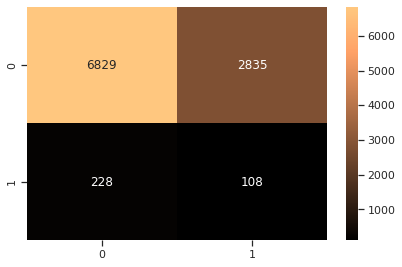

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.636656,0.321429,0.706643,0.198471




Additional Info
Total predicted to be positive: 2943 

Predicted matches
2943 [ 6  7 10 16 22 23 25 28 30 32 37 40 41 42 43 46 49 55 56 57 58 59 62]

[1671 1669 8233 4707  477 6863 8229 1679 3178 8226 8225 1681 8223  194
  573 5538 2276 8218 4719 6871 4720 4723 3617]

Matched draws
Count: 108, Index: (array([   6,   22,  307,  311,  678,  761,  791,  812,  956,  977, 1081,
       1144, 1199, 1252, 1359, 1381, 1387, 1495, 1552, 1661, 1808, 1815,
       1889, 1904, 1961, 2089, 2133, 2189, 2537, 2663, 2677, 2785, 2837,
       2962, 2965, 2976, 3153, 3222, 3252, 3301, 3498, 3542, 3566, 3610,
       3649, 3669, 3799, 3909, 3947, 4031, 4076, 4183, 4206, 4255, 4486,
       4618, 4668, 4738, 4811, 4867, 4878, 5099, 5414, 5553, 5612, 5622,
       5684, 5687, 5983, 6090, 6124, 6163, 6272, 6590, 6737, 6775, 6780,
       6804, 6964, 7022, 7037, 7052, 7330, 7340, 7351, 7389, 7394, 7403,
       7428, 7579, 7637, 7758, 7761, 7778, 8075, 8178, 8179, 8280, 8389,
       8550, 8661, 8792, 9297, 9390, 9

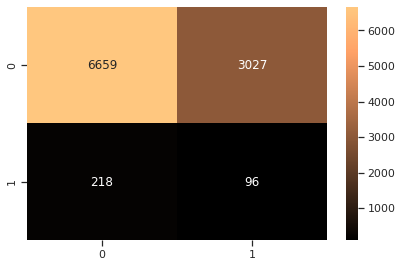

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.631516,0.305732,0.687487,0.182083




Additional Info
Total predicted to be positive: 3123 

Predicted matches
3123 [ 5  6  7 10 15 16 22 23 25 28 30 32 37 39 40 41 42 43 44 46 49 55 56]

[7603 3942 3945 7599 3943 3935 3934 3946 3947 7596 3941 7595 7631 7611
 3926 3917 3913  663 3910 3909 3908 7627  939]

Matched draws
Count: 96, Index: (array([  22,   28,   69,  395,  407,  655,  685,  779,  859, 1210, 1229,
       1268, 1418, 1507, 1518, 1691, 1798, 1900, 1938, 1965, 2039, 2046,
       2116, 2231, 2318, 2327, 2403, 2405, 2787, 2810, 3042, 3070, 3150,
       3391, 3464, 3654, 3664, 3714, 4106, 4351, 5168, 5223, 5414, 5588,
       5688, 5692, 5702, 5858, 6044, 6217, 6274, 6410, 6451, 6490, 6683,
       6693, 6933, 6970, 6993, 7037, 7095, 7119, 7189, 7330, 7352, 7526,
       7611, 7720, 7753, 8087, 8090, 8369, 8492, 8520, 8522, 8594, 8725,
       8804, 8841, 8867, 8929, 8952, 9062, 9093, 9147, 9398, 9417, 9425,
       9478, 9493, 9573, 9683, 9689, 9711, 9764, 9931]),)


Top 23 Possibility
        DrawNo   DrawDate       P

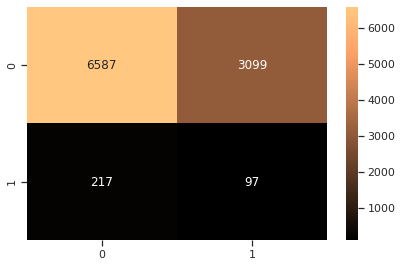

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.637211,0.308917,0.680054,0.183144




Additional Info
Total predicted to be positive: 3196 

Predicted matches
3196 [ 5  6  7 10 15 16 22 23 25 28 30 32 37 39 40 41 42 43 44 46 49 55 56]

[2479 7052 4148 4166 4167 8529 8544 8512 4141 8525 8524 4140 8522 8521
 8520 8519 7074 8517  778 7075 7076 7077  485]

Matched draws
Count: 97, Index: (array([ 213,  287,  347,  356,  380,  502,  532,  738, 1139, 1162, 1350,
       1455, 1465, 1676, 1824, 1829, 1961, 2046, 2059, 2075, 2136, 2231,
       2382, 2393, 2431, 2492, 2506, 2578, 2650, 2693, 2778, 2817, 2876,
       2903, 3008, 3020, 3065, 3084, 3110, 3264, 3340, 3403, 3504, 3664,
       3738, 3774, 4072, 4079, 4108, 4172, 4313, 4486, 4499, 4583, 4876,
       5000, 5008, 5093, 5363, 5378, 5577, 5583, 5585, 5814, 5967, 6410,
       6634, 6742, 6763, 6768, 7006, 7083, 7145, 7241, 7292, 7520, 7578,
       7595, 7611, 7645, 7783, 7898, 8105, 8145, 8185, 8307, 8609, 8696,
       9077, 9141, 9204, 9335, 9413, 9429, 9438, 9485, 9758]),)


Top 23 Possibility
Empty DataFrame
Columns: [D

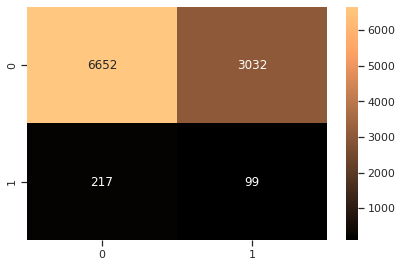

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.627938,0.313291,0.686906,0.188014




Additional Info
Total predicted to be positive: 3131 

Predicted matches
3131 [ 6  7 10 15 16 22 23 25 28 30 32 37 40 41 42 43 44 46 49 55 56 57 58]

[ 386 5603 5616 5622 5590 5588 5586 5585 5612 5583 5681 5631 5632 5638
 5640 5648 5649 5662 5669 5676 5678 5679 5400]

Matched draws
Count: 99, Index: (array([  28,   73,   77,  131,  290,  555,  693,  721,  809,  812,  834,
        851,  905,  907,  924,  939, 1120, 1184, 1234, 1504, 1546, 1674,
       1758, 1782, 1816, 1843, 1876, 2188, 2219, 2494, 2585, 2620, 2672,
       2733, 2842, 3104, 3192, 3244, 3403, 3425, 3534, 3585, 3591, 3612,
       3674, 3719, 3757, 3791, 3901, 3926, 3934, 3979, 3994, 4129, 4350,
       4407, 4550, 4602, 4620, 4719, 4775, 4881, 5057, 5216, 5283, 5355,
       5359, 5443, 5514, 5565, 5569, 5697, 5776, 5823, 5876, 5921, 6011,
       6428, 6506, 6568, 6780, 7123, 7224, 7316, 7588, 7701, 7863, 7935,
       7958, 8271, 8564, 8981, 8984, 9336, 9476, 9527, 9774, 9782, 9899]),)


Top 23 Possibility
Empty DataFrame

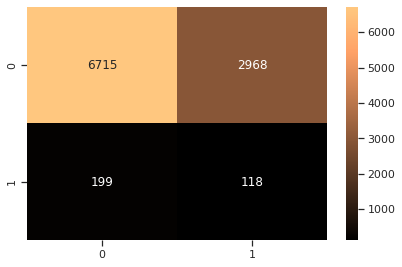

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.625096,0.37224,0.693483,0.236488




Additional Info
Total predicted to be positive: 3086 

Predicted matches
3086 [ 6  7 10 15 16 22 23 25 28 30 32 37 40 41 42 43 44 46 49 55 56 57 58]

[3577 7403 3575  194 7407 3557 3582 3583 7400 3571 7397 3538 3552 7428
 7429 3549 7432 7433 3545 3543 3541 7439 7795]

Matched draws
Count: 118, Index: (array([  59,  123,  322,  364,  435,  443,  460,  469,  502,  639,  717,
        901, 1023, 1129, 1301, 1359, 1372, 1715, 2059, 2136, 2146, 2188,
       2297, 2330, 2371, 2401, 2563, 2604, 2773, 2808, 2810, 3008, 3049,
       3065, 3082, 3162, 3300, 3305, 3404, 3430, 3504, 3552, 3617, 3916,
       3917, 4049, 4075, 4165, 4268, 4296, 4467, 4483, 4621, 4680, 4791,
       4809, 4811, 4928, 5027, 5128, 5195, 5329, 5378, 5450, 5522, 5565,
       5702, 5774, 5832, 5921, 5963, 6070, 6148, 6243, 6246, 6315, 6460,
       6758, 6836, 6879, 6939, 6958, 6971, 7103, 7344, 7362, 7432, 7579,
       7665, 7704, 7709, 7911, 7912, 8151, 8218, 8267, 8362, 8386, 8525,
       8572, 8614, 8726, 8858, 8909, 8

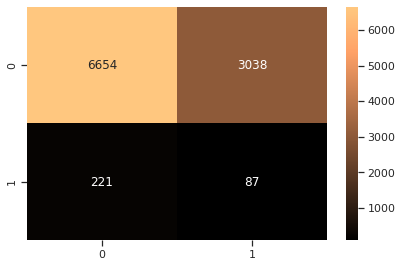

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.62574,0.282468,0.686546,0.163283




Additional Info
Total predicted to be positive: 3125 

Predicted matches
3125 [ 6  7 10 15 16 22 23 25 28 30 32 37 40 41 42 43 44 46 49 55 56 57 58]

[7366 7362 3543 3541 3545 3538 7361 3549 7358 7371 7357  532 3534 7378
 3528 3525 3521 3518 7385 3516 7389 7391 5376]

Matched draws
Count: 87, Index: (array([   7,  347,  362,  559,  595,  897, 1229, 1289, 1348, 1764, 1835,
       1877, 1919, 2110, 2113, 2287, 2296, 2521, 2541, 2620, 2661, 2810,
       2900, 2904, 2939, 3085, 3188, 3238, 3341, 3571, 3583, 3649, 3654,
       3738, 3778, 4037, 4202, 4209, 4386, 4508, 4612, 4629, 4788, 4790,
       4939, 5553, 5690, 5729, 6000, 6054, 6124, 6440, 6486, 6687, 6690,
       6692, 6779, 7083, 7164, 7238, 7611, 7778, 7820, 7860, 8043, 8071,
       8081, 8085, 8128, 8197, 8427, 8447, 8475, 8654, 8984, 9014, 9081,
       9143, 9275, 9370, 9621, 9740, 9821, 9892, 9902, 9916, 9972]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
 

In [ ]:
# Feature_selection
# n_estimators = 300
# ADASYN
# NO remove outliers
# filter features
start_mt = pd.datetime(2019,6,1)
how_many_mt = 7 
for i in range(how_many_mt):
  month_to_predict = start_mt + relativedelta(months=i)
  print(f"\n{month_to_predict}\n-------------------\n")
  %time gen_train_test_set(month_to_predict, feature_matrix_selection, file_prefix='test')
  %time model(month_to_predict, feature_matrix_selection, file_prefix='test')



2019-06-01 00:00:00
-------------------

Training on 889893 observations.
Testing on 10000 observations.

Data shape before balancing: (889893, 62)

Counts of strikes vs non-strikes in previous data:
0    860060
1     29833
Name: Label, dtype: int64
----------------------------------------

NO balancing
Data shape after balancing: (889893, 62)

Counts of strikes VS non-strikes in new data:
0    860060
1     29833
Name: Label, dtype: int64

Filtering features

Data shape before feature selection: (889893, 62)

Counts of strikes vs non-strikes before feature selection:
0    860060
1     29833
Name: Label, dtype: int64
----------------------------------------
----------------------------------------

Data shape after feature selection: (889893, 31)

Counts of strikes vs non-strikes in new data:
0    860060
1     29833
Name: Label, dtype: int64
CPU times: user 11.6 s, sys: 3.65 s, total: 15.2 s
Wall time: 16.6 s
Data shape
(889893, 30) (889893,) (10000, 30) (10000,)

Calculating scale pos

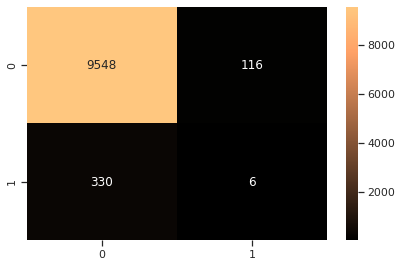

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.49957,0.0178571,0.987997,0.0118851




Additional Info
Total predicted to be positive: 122 

Predicted matches
122 [  6  22  42  44  52 152 163 193 197 201 219 226 253 259 279 283 291 298
 322 352 380 392 498]

[1597  594 2958   42 5301 1531 4060 2479 5311 4609 2107 1949 3105 1047
  392 1271 1207 1553  283 1702 3576  193 7181]

Matched draws
Count: 6, Index: (array([   6,   22,   44,  628, 4663, 5501]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
        DrawNo   DrawDate       PrizeType  LuckyNo
104635  495719 2019-06-08  ConsolationNo5        6
104789  496419 2019-06-22      2ndPrizeNo       44
104802  496419 2019-06-22     SpecialNo10       22
104856  496619 2019-06-26      SpecialNo9        6


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
104635  495719 2019-06-08  ConsolationNo5        6
104789  496419 2019-06-22      2ndPrizeNo       44
104802  496419 2019-06-22     SpecialNo10       22
104807  496419 2019-06-22      SpecialNo6 

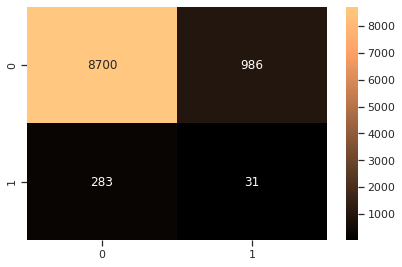

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.501509,0.0987261,0.898204,0.0586216




Additional Info
Total predicted to be positive: 1017 

Predicted matches
1017 [ 0  5  9 13 17 18 28 29 33 35 38 42 45 50 52 54 62 64 66 67 72 73 77]

[ 594  193  817 5311  823 3591   35 5301  851  895  903 1271  905  581
  661  950 1949 2479  592  298  479 6114  210]

Matched draws
Count: 31, Index: (array([  28,   66,  261,  275,  333,  463,  476,  502,  559,  843,  859,
       1085, 1093, 1156, 1178, 1268, 1374, 1618, 2117, 2327, 2405, 2611,
       2692, 3150, 3211, 3654, 3664, 6550, 7173, 7436, 8556]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
        DrawNo   DrawDate       PrizeType  LuckyNo
104996  497319 2019-07-13      2ndPrizeNo       28
105186  498119 2019-07-30  ConsolationNo4       66


All matched
        DrawNo   DrawDate        PrizeType  LuckyNo
104918  496919 2019-07-03       SpecialNo2     3654
104933  497019 2019-07-06   ConsolationNo4     2405
104961  497119 2019-07-07   ConsolationNo9     26

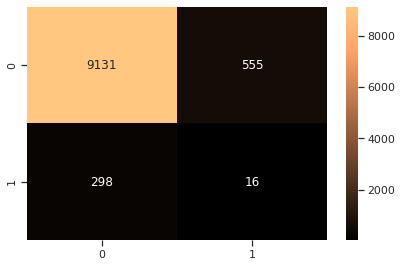

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.501798,0.0509554,0.942701,0.0293045




Additional Info
Total predicted to be positive: 571 

Predicted matches
571 [  0  13  18  28  35  38  49  50  52  54  72 115 129 131 132 151 152 157
 191 193 197 199 201]

[ 950  743 1702  952  895 1253  716  810  823 1017 1124 1933 5311  496
 7455 8938  592  757 1271 7227  905 1949  903]

Matched draws
Count: 16, Index: (array([ 743,  806, 1018, 1164, 1217, 2037, 2205, 4223, 5051, 5378, 6114,
       6510, 6742, 7466, 7976, 9355]),)


Top 23 Possibility
        DrawNo   DrawDate       PrizeType  LuckyNo
105532  499619 2019-08-31  ConsolationNo5      743


First 23 Numbers
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
105277  498519 2019-08-07  ConsolationNo3     5051
105291  498519 2019-08-07      SpecialNo7     5378
105303  498619 2019-08-10  ConsolationNo6      806
105307  498619 2019-08-10      SpecialNo1     1018
105327  498719 2019-08-11  ConsolationNo7     1164
105340  498819 2019-08-14

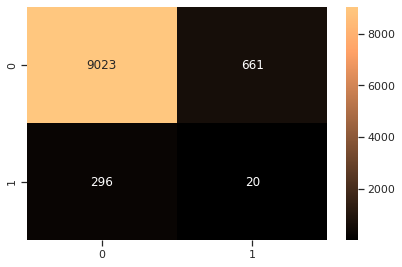

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.500105,0.0632911,0.931743,0.0369815




Additional Info
Total predicted to be positive: 681 

Predicted matches
681 [  0   6  18  19  28  33  35  38  42  52  54  72  83  90 110 113 115 121
 131 147 151 181 184]

[8690 7836 1124 3111 8981  950 1933 4465 3591 7455 5378   19 8938  592
 2479  905  823 5311 1271 5301 4562 3114 1949]

Matched draws
Count: 20, Index: (array([  28,  131,  622,  693,  732,  764,  809,  851,  905, 1504, 1828,
       1854, 2449, 3576, 3591, 3994, 5064, 6898, 8079, 8981]),)


Top 23 Possibility
        DrawNo   DrawDate   PrizeType  LuckyNo
105614  499919 2019-09-07  SpecialNo8     8981
105632  500019 2019-09-08  SpecialNo3      905
105687  500319 2019-09-14  3rdPrizeNo     3591
105862  501019 2019-09-29  SpecialNo3      905


First 23 Numbers
        DrawNo   DrawDate   PrizeType  LuckyNo
105617  500019 2019-09-08  2ndPrizeNo       28
105631  500019 2019-09-08  SpecialNo2      131


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
105557  499719 2019-09-01  ConsolationNo7      851
10557

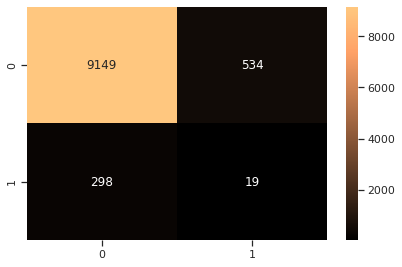

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.499977,0.0599369,0.944852,0.0369199




Additional Info
Total predicted to be positive: 553 

Predicted matches
553 [ 11  18  19  28  35  38  42  54  65  72 102 113 115 121 163 184 193 197
 203 210 216 220 225]

[3591   19 4609 1606  905 8938 7227 1271 7586 7455 8981 5311 4465 9258
  823  950  592 5301 8690 1933 1949 2479 1124]

Matched draws
Count: 19, Index: (array([  38,  305,  540,  639,  823, 1004, 1301, 1372, 1813, 2227, 2330,
       2401, 3882, 4928, 5191, 5378, 6649, 6977, 8761]),)


Top 23 Possibility
        DrawNo   DrawDate   PrizeType  LuckyNo
106003  501619 2019-10-12  SpecialNo6      823


First 23 Numbers
        DrawNo   DrawDate    PrizeType  LuckyNo
106182  502419 2019-10-30  SpecialNo10       38


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
105916  501319 2019-10-05      2ndPrizeNo     4928
105959  501419 2019-10-06      SpecialNo8     1301
106003  501619 2019-10-12      SpecialNo6      823
106017  501719 2019-10-13  ConsolationNo7     2227
106018  501719 2019-10-13  ConsolationNo8   

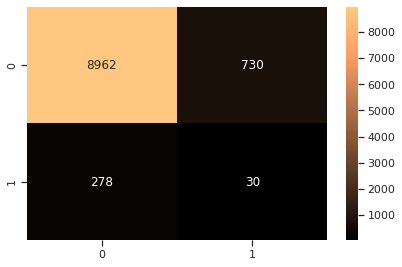

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.500169,0.0974026,0.92468,0.0628581




Additional Info
Total predicted to be positive: 760 

Predicted matches
760 [ 18  19  28  35  49  54  72 102 113 115 177 184 193 197 203 210 216 219
 220 222 226 229 240]

[4465  905   19 7139 3591 2479 1933 7227 3114 1124 8981 8938 1949 1271
 6114  823 5311 9258 5301 7455  592  950 5378]

Matched draws
Count: 30, Index: (array([ 595,  622,  647,  722,  753,  897, 1008, 1043, 1289, 1352, 2302,
       2363, 2482, 2620, 3515, 4465, 4647, 5080, 5116, 6188, 6779, 7135,
       7181, 7187, 7539, 7601, 7741, 8427, 8505, 9020]),)


Top 23 Possibility
        DrawNo   DrawDate   PrizeType  LuckyNo
106344  503119 2019-11-13  SpecialNo2     4465


First 23 Numbers
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


All matched
        DrawNo   DrawDate        PrizeType  LuckyNo
106191  502519 2019-11-02       1stPrizeNo      753
106195  502519 2019-11-02  ConsolationNo10     1352
106224  502619 2019-11-03   ConsolationNo7     2363
106228  502619 2019-11-03      SpecialNo

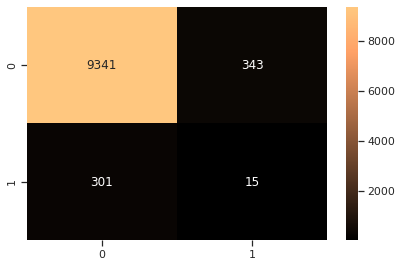

,Train_Recall,Test_Recall,Test_Specificity,Optimize
XGBClassifier_optimize,0.500752,0.0474684,0.964581,0.0308908




Additional Info
Total predicted to be positive: 358 

Predicted matches
358 [  6  13  19  28  33  35  42  52  54  72  83 102 111 113 115 121 131 152
 163 193 197 203 210]

[3591  903 4609 4562 1271 5301 7455 1933  950 1124 1949  592 8981 4465
   19 7836 5378 3114 6114 9258  823 8690 2479]

Matched draws
Count: 15, Index: (array([ 197,  322,  572,  594,  622,  708, 1082, 3098, 3497, 4267, 5294,
       5629, 8216, 8476, 9964]),)


Top 23 Possibility
Empty DataFrame
Columns: [DrawNo, DrawDate, PrizeType, LuckyNo]
Index: []


First 23 Numbers
        DrawNo   DrawDate       PrizeType  LuckyNo
106613  504319 2019-12-08  ConsolationNo5      197


All matched
        DrawNo   DrawDate       PrizeType  LuckyNo
106516  503919 2019-12-01  ConsolationNo1     3098
106525  503919 2019-12-01  ConsolationNo9      572
106539  504019 2019-12-03  ConsolationNo1     3497
106595  504219 2019-12-07      SpecialNo1      622
106611  504319 2019-12-08  ConsolationNo3     8216
106613  504319 2019-12-08  Cons

In [27]:
# Feature_selection
# n_estimators = 300
# NO remove outliers
# filter features
start_mt = pd.datetime(2019,6,1)
how_many_mt = 7 
for i in range(how_many_mt):
  month_to_predict = start_mt + relativedelta(months=i)
  print(f"\n{month_to_predict}\n-------------------\n")
  %time gen_train_test_set(month_to_predict, feature_matrix_selection, file_prefix='test')
  %time model(month_to_predict, feature_matrix_selection, file_prefix='test')